https://github.com/google-research/scenic/blob/main/scenic/projects/owl_vit/notebooks/OWL_ViT_minimal_example.ipynb

In [1]:
%matplotlib inline

import jax
import jax.numpy as jnp
from scenic.projects.owl_vit import configs
from scenic.projects.owl_vit import models
print("Using", jax.default_backend())

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-21 04:43:16.697780: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Using gpu


In [2]:
config = configs.owl_v2_clip_b16.get_config(init_mode='canonical_checkpoint')

In [3]:
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    objectness_head_configs=config.model.objectness_head,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

In [4]:
variables = module.load_variables("checkpoints/owl_vit")

In [7]:
import numpy as np
def pad_square(image: np.ndarray) -> np.ndarray:
    """Pads an image with black pixels to make it square.

    This method assumes that image is a height x width x channels array. The
    padding is added to the right or the bottom of the image so that it can be
    removed without affecting annotations in the coordinate space.
    """
    height, width = image.shape[:2]
    if height == width:
        return image
    
    if height > width:
        pad_value = np.zeros((
            height, height - width, image.shape[2]), dtype=image.dtype)
        return np.concatenate((image, pad_value), axis=1)
    else:
        pad_value = np.zeros((
            width - height, width, image.shape[2]), dtype=image.dtype)
        return np.concatenate((image, pad_value), axis=0)

In [8]:
jitted = jax.jit(module.apply, static_argnames=('train',))

## Text Prompt

In [25]:
import PIL
import numpy as np

PIL.Image.MAX_IMAGE_PIXELS = 933120000
image_name = 'arleigh-burke.jpeg'
image = PIL.Image.open(image_name)
image_arr = jnp.array(image) / 255.0
print(image_arr.shape)

(3292, 5350, 3)


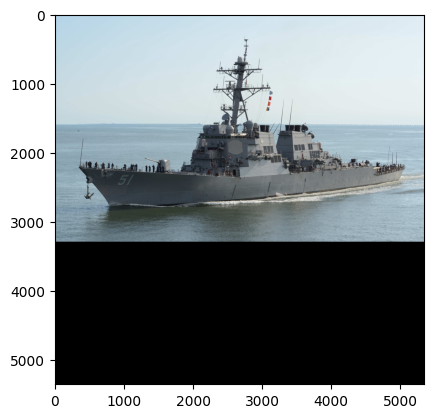

In [26]:
from matplotlib import pyplot as plt

padded = pad_square(image_arr)
plt.imshow(padded)
plt.show()

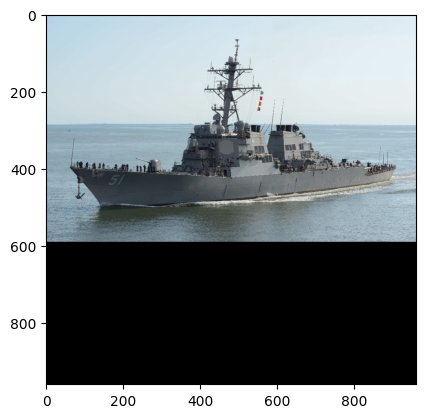

CPU times: user 299 ms, sys: 160 ms, total: 459 ms
Wall time: 160 ms


In [27]:
%%time

import cv2
resized = cv2.resize(padded, dsize=(config.dataset_configs.input_size, config.dataset_configs.input_size), interpolation=cv2.INTER_CUBIC)
plt.imshow(resized)
plt.show()

In [83]:
text_queries = ['arleigh burke']
tokenized_queries = np.array([
    module.tokenize(q, config.dataset_configs.max_query_length)
    for q in text_queries
])

# Pad tokenized queries to avoid recompilation if number of queries changes:
tokenized_queries = np.pad(
    tokenized_queries,
    pad_width=((0, 100 - len(text_queries)), (0, 0)),
    constant_values=0)
print(tokenized_queries[None, ...].shape)

(1, 100, 16)


In [37]:
%%time

predictions = jitted(
    variables,
    resized[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_util.tree_map(lambda x: np.array(x[0]), predictions )

CPU times: user 504 ms, sys: 4.06 ms, total: 508 ms
Wall time: 294 ms


In [38]:
from scipy.special import expit as sigmoid

score_threshold = 0.2

logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
scores = sigmoid(np.max(logits, axis=-1))
labels = np.argmax(predictions['pred_logits'], axis=-1)
boxes = predictions['pred_boxes']

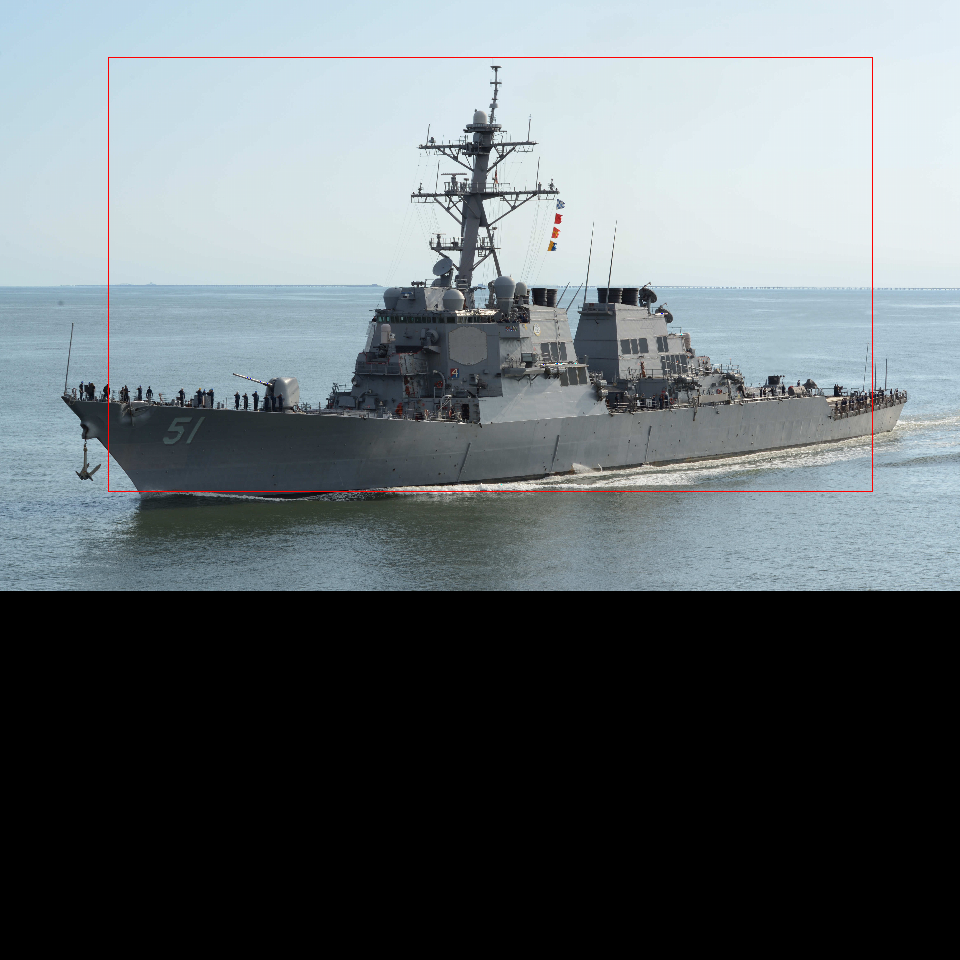

In [39]:
im = PIL.Image.fromarray(np.uint8(resized*255))
draw = PIL.ImageDraw.Draw(im)
for score, box, label in zip(scores, boxes, labels):
    if score < score_threshold:
        continue
    cx, cy, w, h = box
    cx = cx * config.dataset_configs.input_size
    cy = cy * config.dataset_configs.input_size
    w = w * config.dataset_configs.input_size
    h = h * config.dataset_configs.input_size
    x1 = cx - int(w/2)
    y1 = cy - int(h/2)
    x2 = cx + int(w/2)
    y2 = cy + int(h/2)
    draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
display(im)

## Objectness

In [9]:
import PIL
import numpy as np

PIL.Image.MAX_IMAGE_PIXELS = 933120000
image_name = 'arleigh-burke.jpeg'
image = PIL.Image.open(image_name)
image_arr = jnp.array(image) / 255.0
print(image_arr.shape)

(3292, 5350, 3)


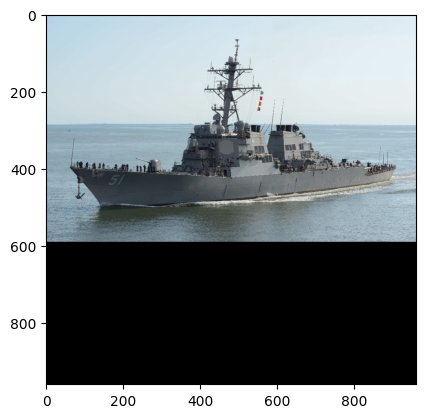

In [10]:
import cv2
from matplotlib import pyplot as plt

padded = pad_square(image_arr)
resized = cv2.resize(padded, dsize=(config.dataset_configs.input_size, config.dataset_configs.input_size), interpolation=cv2.INTER_CUBIC)
plt.imshow(resized)
plt.show()

In [16]:
text_queries = ['boat']
tokenized_queries = np.array([
    module.tokenize(q, config.dataset_configs.max_query_length)
    for q in text_queries
])

# Pad tokenized queries to avoid recompilation if number of queries changes:
tokenized_queries = np.pad(
    tokenized_queries,
    pad_width=((0, 100 - len(text_queries)), (0, 0)),
    constant_values=0)
print(tokenized_queries.shape)

(100, 16)


In [19]:
%%time
# Note: The model expects a batch dimension.
predictions = jitted(
    variables,
    resized[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_util.tree_map(lambda x: np.array(x[0]), predictions )

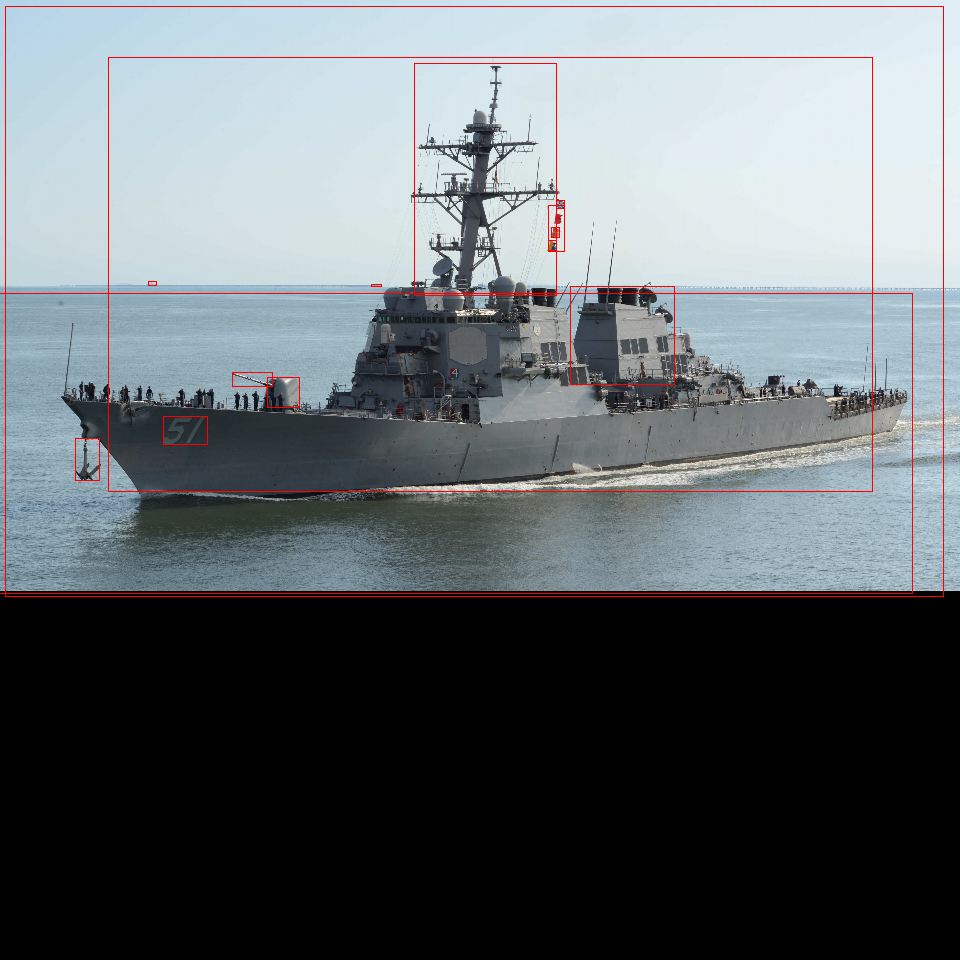

In [24]:
from scipy.special import expit as sigmoid

im = PIL.Image.fromarray(np.uint8(resized*255))
draw = PIL.ImageDraw.Draw(im)

top_k = 15
objectnesses = sigmoid(predictions['objectness_logits'])
boxes = predictions['pred_boxes']

objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]

for box, objectness in zip(boxes, objectnesses):
    if objectness < objectness_threshold:
        continue
    cx, cy, w, h = box
    cx = cx * config.dataset_configs.input_size
    cy = cy * config.dataset_configs.input_size
    w = w * config.dataset_configs.input_size
    h = h * config.dataset_configs.input_size
    x1 = cx - int(w/2)
    y1 = cy - int(h/2)
    x2 = cx + int(w/2)
    y2 = cy + int(h/2)
    draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
display(im)

## Image Guided Search

In [58]:
import PIL
import numpy as np

PIL.Image.MAX_IMAGE_PIXELS = 933120000
target_name = 'large-sat-image-docks.png'
target = PIL.Image.open(target_name)
target_arr = jnp.array(target) / 255.0
target_padded = pad_square(target_arr)
target_resized = cv2.resize(target_padded, dsize=(config.dataset_configs.input_size, config.dataset_configs.input_size), interpolation=cv2.INTER_CUBIC)

query_name = 'single-ship.png'
query = PIL.Image.open(query_name)
query_arr = jnp.array(query) / 255.0
query_padded = pad_square(query_arr)
query_resized = cv2.resize(query_padded, dsize=(config.dataset_configs.input_size, config.dataset_configs.input_size), interpolation=cv2.INTER_CUBIC)

In [59]:
import functools

image_embedder = jax.jit(
    functools.partial(
        module.apply, variables, train=False, method=module.image_embedder
    )
)

objectness_predictor = jax.jit(
    functools.partial(
        module.apply, variables, method=module.objectness_predictor
    )
)

box_predictor = jax.jit(
    functools.partial(module.apply, variables, method=module.box_predictor)
)

class_predictor = jax.jit(
    functools.partial(module.apply, variables, method=module.class_predictor)
)

In [60]:
# Embedd images and get boxes, without text queries:
feature_map = image_embedder(query_resized[None, ...])

b, h, w, d = feature_map.shape
image_features = feature_map.reshape(b, h * w, d)

objectnesses = objectness_predictor(image_features)['objectness_logits']

source_boxes = box_predictor(
    image_features=image_features, feature_map=feature_map
)['pred_boxes']

source_class_embeddings = class_predictor(image_features=image_features)[
    'class_embeddings'
]

# Remove batch dimension
objectnesses = np.array(objectnesses[0])
source_boxes = np.array(source_boxes[0])
source_class_embeddings = np.array(source_class_embeddings[0])

top_k = 1
objectnesses = sigmoid(objectnesses)
objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]

1098


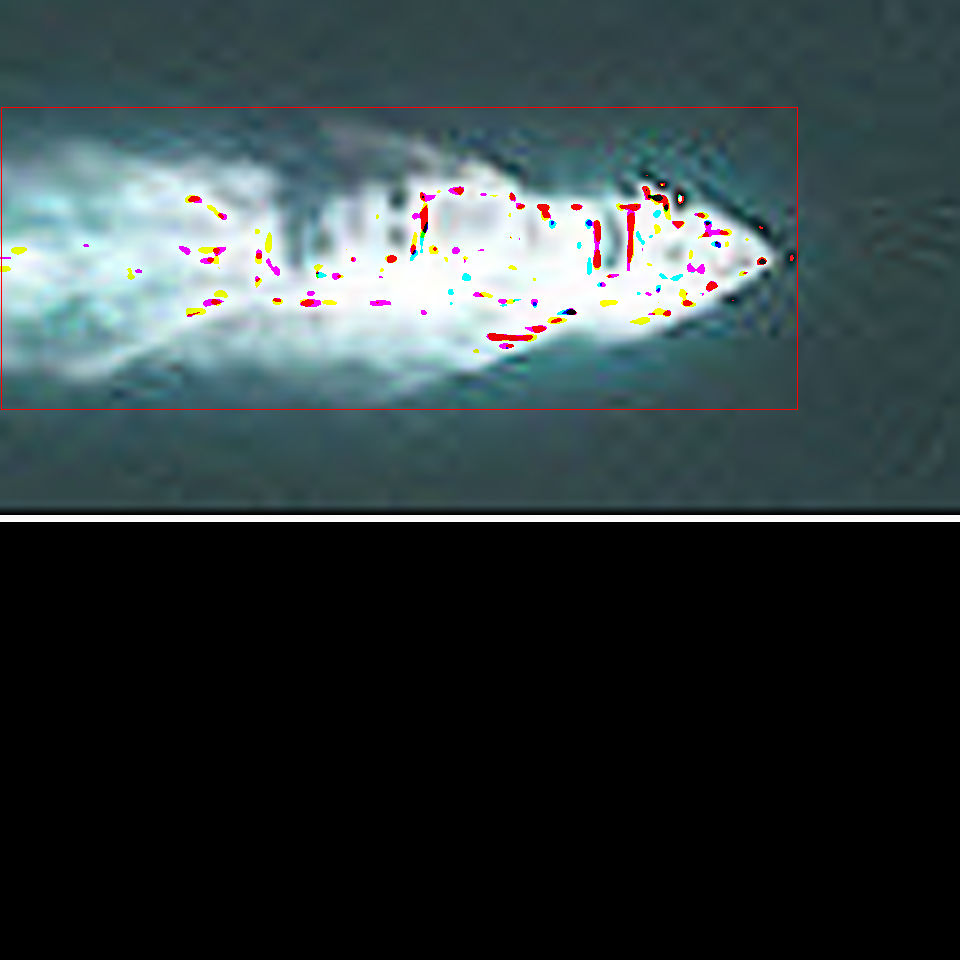

In [61]:
im = PIL.Image.fromarray(np.uint8(query_resized*255))
draw = PIL.ImageDraw.Draw(im)

for i, (box, objectness) in enumerate(zip(source_boxes, objectnesses)):
    if objectness < objectness_threshold:
        continue
    cx, cy, w, h = box
    cx = cx * config.dataset_configs.input_size
    cy = cy * config.dataset_configs.input_size
    w = w * config.dataset_configs.input_size
    h = h * config.dataset_configs.input_size
    x1 = cx - int(w/2)
    y1 = cy - int(h/2)
    x2 = cx + int(w/2)
    y2 = cy + int(h/2)
    draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
    print(i)
display(im)

In [63]:
# Get the query embedding with the index of the selected object.
# We're using the rocket:
query_object_index = 1098  # Index of the rocket box above.
query_embedding = source_class_embeddings[query_object_index]

In [77]:
feature_map = image_embedder(target_resized[None, ...])

b, h, w, d = feature_map.shape
target_boxes = box_predictor(
    image_features=feature_map.reshape(b, h * w, d), feature_map=feature_map
)['pred_boxes']

target_class_predictions = class_predictor(
    image_features=feature_map.reshape(b, h * w, d),
    query_embeddings=query_embedding[None, None, ...],  # [batch, queries, d]
)


# Remove batch dimension and convert to numpy:
boxes = np.array(target_boxes[0])
target_logits = np.array(target_class_predictions['pred_logits'][0])

top_ind = np.argmax(target_logits[:, 0], axis=0)
score = sigmoid(target_logits[top_ind, 0])
print(score)

scores = sigmoid(np.max(target_logits, axis=-1))

0.9658519


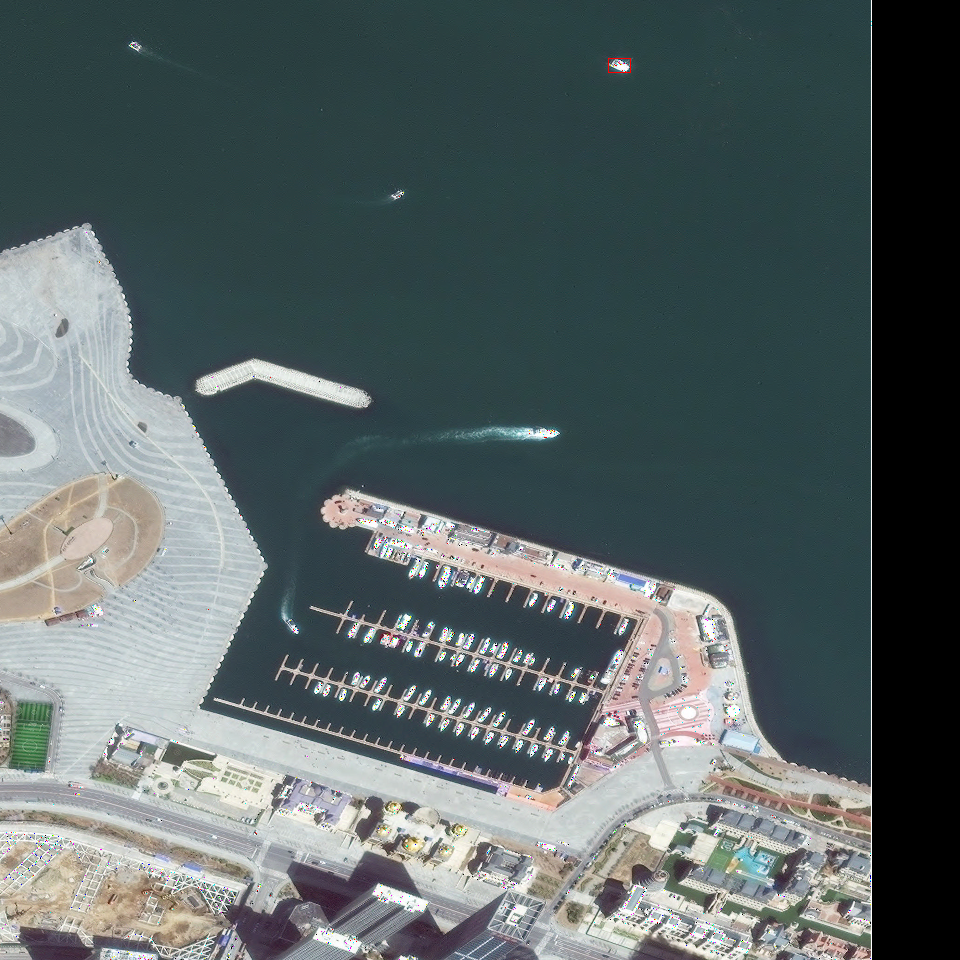

In [78]:
im = PIL.Image.fromarray(np.uint8(target_resized*255))
draw = PIL.ImageDraw.Draw(im)

cx, cy, w, h = boxes[top_ind]
cx = cx * config.dataset_configs.input_size
cy = cy * config.dataset_configs.input_size
w = w * config.dataset_configs.input_size
h = h * config.dataset_configs.input_size
x1 = cx - int(w/2)
y1 = cy - int(h/2)
x2 = cx + int(w/2)
y2 = cy + int(h/2)
draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
display(im)

(3600,)


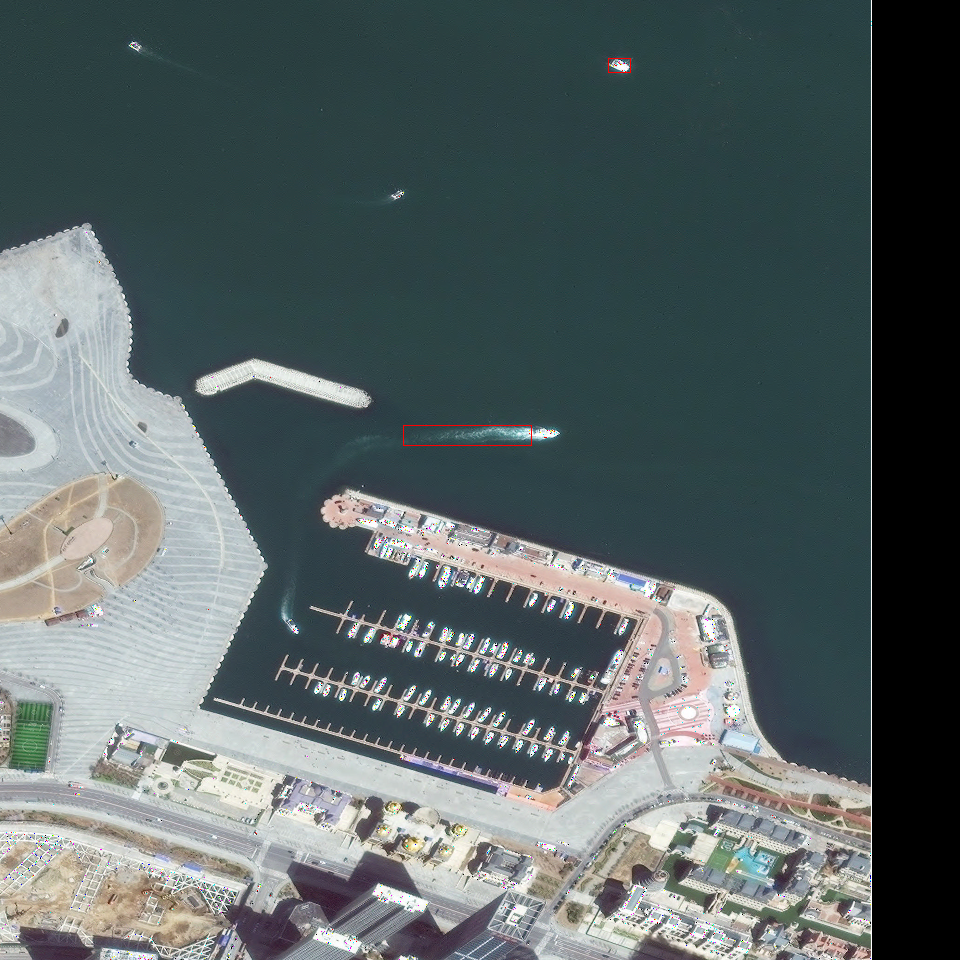

In [82]:
im = PIL.Image.fromarray(np.uint8(target_resized*255))
draw = PIL.ImageDraw.Draw(im)
print(scores.shape)
for score, box in zip(scores, boxes):
    if score < 0.95:
        continue
    cx, cy, w, h = box
    cx = cx * config.dataset_configs.input_size
    cy = cy * config.dataset_configs.input_size
    w = w * config.dataset_configs.input_size
    h = h * config.dataset_configs.input_size
    x1 = cx - int(w/2)
    y1 = cy - int(h/2)
    x2 = cx + int(w/2)
    y2 = cy + int(h/2)
    draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
display(im)